In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd
import tensorflow as tf
import shap

In [41]:
data = pd.read_csv('snapp_data.csv')
data.isnull().sum()

origin_lat              0
origin_lng              0
destination_lat         0
destination_lng         0
price_normal_final      0
price_normal_raw        0
price_bike_final      280
price_bike_raw        280
timestamp               0
surge                   0
distance              171
duration              171
dtype: int64

In [42]:
data = data.dropna(subset=['distance', 'duration'])
print('length of snapp data: ',len(data))
print('min price: ',data['price_normal_final'].min(),', max price: ',data['price_normal_final'].max())
data['price_normal_final'] = data['price_normal_final'] / 10000
data.head()

length of snapp data:  1937
min price:  230000 , max price:  8130000


,origin_lat,origin_lng,destination_lat,destination_lng,price_normal_final,price_normal_raw,price_bike_final,price_bike_raw,timestamp,surge,distance,duration
0,35.539870,51.070069,35.729916,51.273109,122.0,1220000,1455000.0,1455000.0,1722120772,False,39498.88798,2510.597999
1,35.551331,51.094218,35.799337,51.265725,123.0,1230000,1485000.0,1485000.0,1722148132,False,46224.75693,2997.599999
2,35.707471,51.265685,35.588419,51.203152,87.0,870000,1185000.0,1185000.0,1722148740,False,19792.11396,1879.825999
3,35.718585,51.220815,35.804200,51.540530,127.0,1410000,1645000.0,1645000.0,1722149213,False,40965.74404,2655.097999
4,35.771466,51.251511,35.746627,51.572205,152.0,1520000,1765000.0,1765000.0,1722149220,False,36172.63159,2451.475000


In [43]:
data['hour'] = pd.to_datetime(data['timestamp'], unit='s').dt.hour
data['minute'] = pd.to_datetime(data['timestamp'], unit='s').dt.minute
data['dayofweek'] = pd.to_datetime(data['timestamp'], unit='s').dt.dayofweek
data['distance_geo'] = np.sqrt((data['origin_lat'] - data['destination_lat'])**2 + (data['origin_lng'] - data['destination_lng'])**2)
data.head()

,origin_lat,origin_lng,destination_lat,destination_lng,price_normal_final,price_normal_raw,price_bike_final,price_bike_raw,timestamp,surge,distance,duration,hour,minute,dayofweek,distance_geo
0,35.539870,51.070069,35.729916,51.273109,122.0,1220000,1455000.0,1455000.0,1722120772,False,39498.88798,2510.597999,22,52,5,0.278106
1,35.551331,51.094218,35.799337,51.265725,123.0,1230000,1485000.0,1485000.0,1722148132,False,46224.75693,2997.599999,6,28,6,0.301532
2,35.707471,51.265685,35.588419,51.203152,87.0,870000,1185000.0,1185000.0,1722148740,False,19792.11396,1879.825999,6,39,6,0.134476
3,35.718585,51.220815,35.804200,51.540530,127.0,1410000,1645000.0,1645000.0,1722149213,False,40965.74404,2655.097999,6,46,6,0.330980
4,35.771466,51.251511,35.746627,51.572205,152.0,1520000,1765000.0,1765000.0,1722149220,False,36172.63159,2451.475000,6,47,6,0.321655


In [44]:
features = ['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng', 'hour','surge', 'dayofweek', 'distance', 'duration', 'distance_geo']
target = 'price_normal_final'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [45]:
# ساخت مدل شبکه عصبی
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=256, activation='relu', input_dim=X_train.shape[1]))
ann.add(tf.keras.layers.BatchNormalization())
ann.add(tf.keras.layers.Dropout(0.4))

ann.add(tf.keras.layers.Dense(units=512, activation='relu'))
ann.add(tf.keras.layers.BatchNormalization())
ann.add(tf.keras.layers.Dropout(0.4))

ann.add(tf.keras.layers.Dense(units=512, activation='relu'))
ann.add(tf.keras.layers.BatchNormalization())
ann.add(tf.keras.layers.Dropout(0.4))

ann.add(tf.keras.layers.Dense(units=256, activation='relu'))
ann.add(tf.keras.layers.BatchNormalization())
ann.add(tf.keras.layers.Dropout(0.4))

ann.add(tf.keras.layers.Dense(units=128, activation='relu'))
ann.add(tf.keras.layers.BatchNormalization())
ann.add(tf.keras.layers.Dropout(0.4))

ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.BatchNormalization())
ann.add(tf.keras.layers.Dense(units=1))

ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_absolute_error', metrics=['mae'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = ann.fit(X_train, y_train, batch_size=32, epochs=2000, validation_split=0.2, callbacks=[early_stopping])

loss, mae = ann.evaluate(X_test, y_test)
print(f'Mean Absolute Error on test set: {mae}')


Epoch 1/2000
39/39 [==============================] - 1s 14ms/step - loss: 174.8533 - mae: 174.8533 - val_loss: 172.5478 - val_mae: 172.5478
Epoch 2/2000
39/39 [==============================] - 0s 9ms/step - loss: 174.8084 - mae: 174.8084 - val_loss: 172.2921 - val_mae: 172.2921
Epoch 3/2000
39/39 [==============================] - 0s 8ms/step - loss: 174.7597 - mae: 174.7597 - val_loss: 172.1320 - val_mae: 172.1320
Epoch 4/2000
39/39 [==============================] - 0s 6ms/step - loss: 174.7069 - mae: 174.7069 - val_loss: 171.9918 - val_mae: 171.9918
Epoch 5/2000
39/39 [==============================] - 0s 6ms/step - loss: 174.6499 - mae: 174.6499 - val_loss: 171.9093 - val_mae: 171.9093
Epoch 6/2000
39/39 [==============================] - 0s 6ms/step - loss: 174.5885 - mae: 174.5885 - val_loss: 171.7879 - val_mae: 171.7879
Epoch 7/2000
39/39 [==============================] - 0s 6ms/step - loss: 174.5229 - mae: 174.5229 - val_loss: 171.7120 - val_mae: 171.7120
Epoch 8/2000
39/39 

In [46]:
ann.save('model.keras')

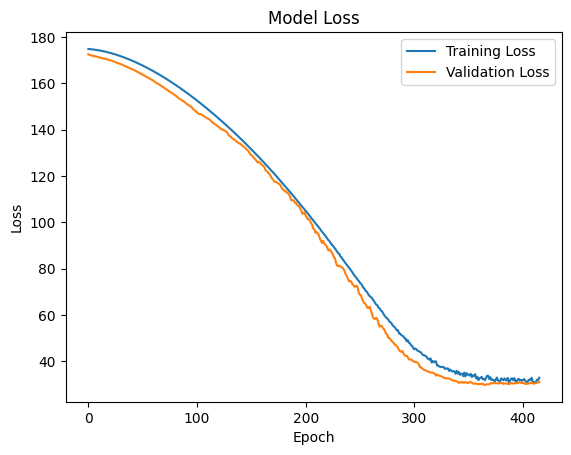

In [47]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


ExactExplainer explainer: 389it [00:19,  9.50it/s]                         


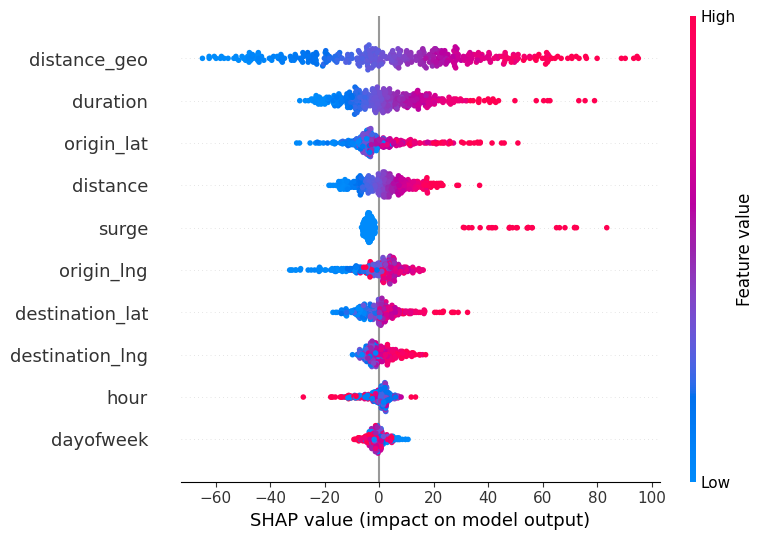

In [48]:
explainer = shap.Explainer(ann, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)

In [49]:
test_data = pd.read_csv('snapp_data_test.csv')
test_data['price_normal_final'] = test_data['price_normal_final'] / 10000
test_data = test_data.dropna(subset=['distance', 'duration'])

test_data['hour'] = pd.to_datetime(test_data['timestamp'], unit='s').dt.hour
test_data['minute'] = pd.to_datetime(test_data['timestamp'], unit='s').dt.minute
test_data['dayofweek'] = pd.to_datetime(test_data['timestamp'], unit='s').dt.dayofweek
test_data['distance_geo'] = np.sqrt((test_data['origin_lat'] - test_data['destination_lat'])**2 + (test_data['origin_lng'] - test_data['destination_lng'])**2)

features = ['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng', 'hour','surge', 'dayofweek', 'distance', 'duration', 'distance_geo']
target = 'price_normal_final'

test_data = test_data
X = test_data[features]
y = test_data[target]

X=sc.transform(X)
predicted_price_test = ann.predict(X)
predicted_price_test = predicted_price_test.flatten()
y = np.array(y)

df = pd.DataFrame({
    'Real Price': y.astype(int),
    'Predicted Price': predicted_price_test.astype(int)
})
print(df)

1/1 [==============================] - 0s 96ms/step
    Real Price  Predicted Price
0          193              174
1          217              232
2           66               93
3          122              136
4          172              140
5          157              157
6          188              119
7          109              134
8           85              112
9          283              226
10         259              181
11         104              133
12         222              157
13         131              155
14         205              165
15         249              194
16         287              186
17         247              268
18          73              103
19         205              175


In [50]:
epsilon = 1e-10
np.mean(np.abs(y - predicted_price_test))

37.972368240356445